# iQuack2024, QuEra Challenge, Dirac Dawgs

### Masarah Ahmedhussain, Elizabeth Foster, Avery Hanna, Noah Stiegler, Tema Zulu


Notes from Elizabeth:
I've been adding in questions that we need to answer throughout the night. The result should lead to some really good, well documented code and decisions

We begin by building our graph, a defective king's lattice, where vertices are positioned in a square lattice with a few vertices removed randomly.

1. How dense do we want the graph? Like, how many kings do we want to be disappeared? This metric is probably a way to describe the annealing hardness parameters of the problem instances we've found. Look into what sparse lattices result in
2. What scale are we working with? How far apart do we want each qubit?


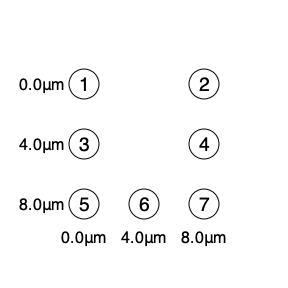

In [192]:
using Graphs
using Bloqade
using Random
using GenericTensorNetworks
using Optim
using PythonCall
plt = pyimport("matplotlib.pyplot");

# To begin, we create a ``4 \times 4`` DUGG with 0.8 filling, by using the [`random_dropout`](@ref) function. 
# Here, we choose the lattice constant ``a`` to be 4.5 μm: 
Random.seed!(2)
atoms = generate_sites(SquareLattice(), 3, 3; scale = 4) |> random_dropout(0.2)
            

# Setting the Blockade Radius
1. What are we setting the Blockade Radius to? This is an Very big questions that is being asked

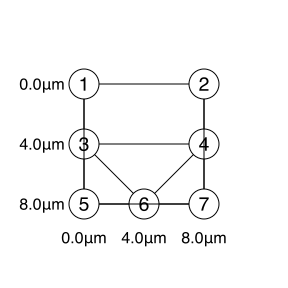

In [193]:
# Next, we set the blockade radius to be 7.5 μm, 
# corresponding to a case where nearest neighbors and next-nearest neighbors (diagonal from the initial atom) are within the blockade radius.
# As we discussed in the [Rydberg Blockade](@ref blockade) tutorial, only one Rydberg excitation is allowed within the blockade radius.  
# To better illustrate this constraint, we 
# plot the interactions of Rydberg atoms as a DUGG, where each edge corresponds to the blockade constraint given by the blockade radius: 
Bloqade.plot(atoms, blockade_radius = 8.46)

# The Classical Approach:

A great comparision, we can get the MIS and the total possible number of MISs Would be cool to wrap this approach in timing.

In [194]:
# Our goal is to find a maximum independent set of such a graph.

# For comparison, we first use classical algorithms to calculate the MIS size here using the graph utilities in Bloqade, 
# so that one can compare this exact result with the quantum algorithms.
# The exact MIS size and its degeneracy can be solved with
# the [generic tensor network algorithm (J. Liu et al. (10.48550/arXiv.2205.03718))](https://arxiv.org/pdf/2205.03718.pdf) 
# in the package [`GenericTensorNetworks`](https://github.com/QuEraComputing/GenericTensorNetworks.jl):
graph = BloqadeMIS.unit_disk_graph(atoms, 8.46)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph), CountingMax())[]

# The `solve` function takes a graph instance and a solution space property as inputs,
# where the graph instance is generated by the [`unit_disk_graph`](@ref) function in the Bloqade submodule `BloqadeMIS`,
# and the solution space property is to count the number of maximum independent sets here.
# The first number outputted is the number of vertices in the MIS, and the second number is the number of MIS solutions
# In the following, we are going to show how to solve the independent set problem with both quantum adiabatic and variational algorithms.


(2.0, 8.0)ₜ

# The Adiabatic Approach:

This is where we get to make a lot of the choices that we've been considering so far:
1. The Rabi frequency (Omega)
2. The detuning (Delta)

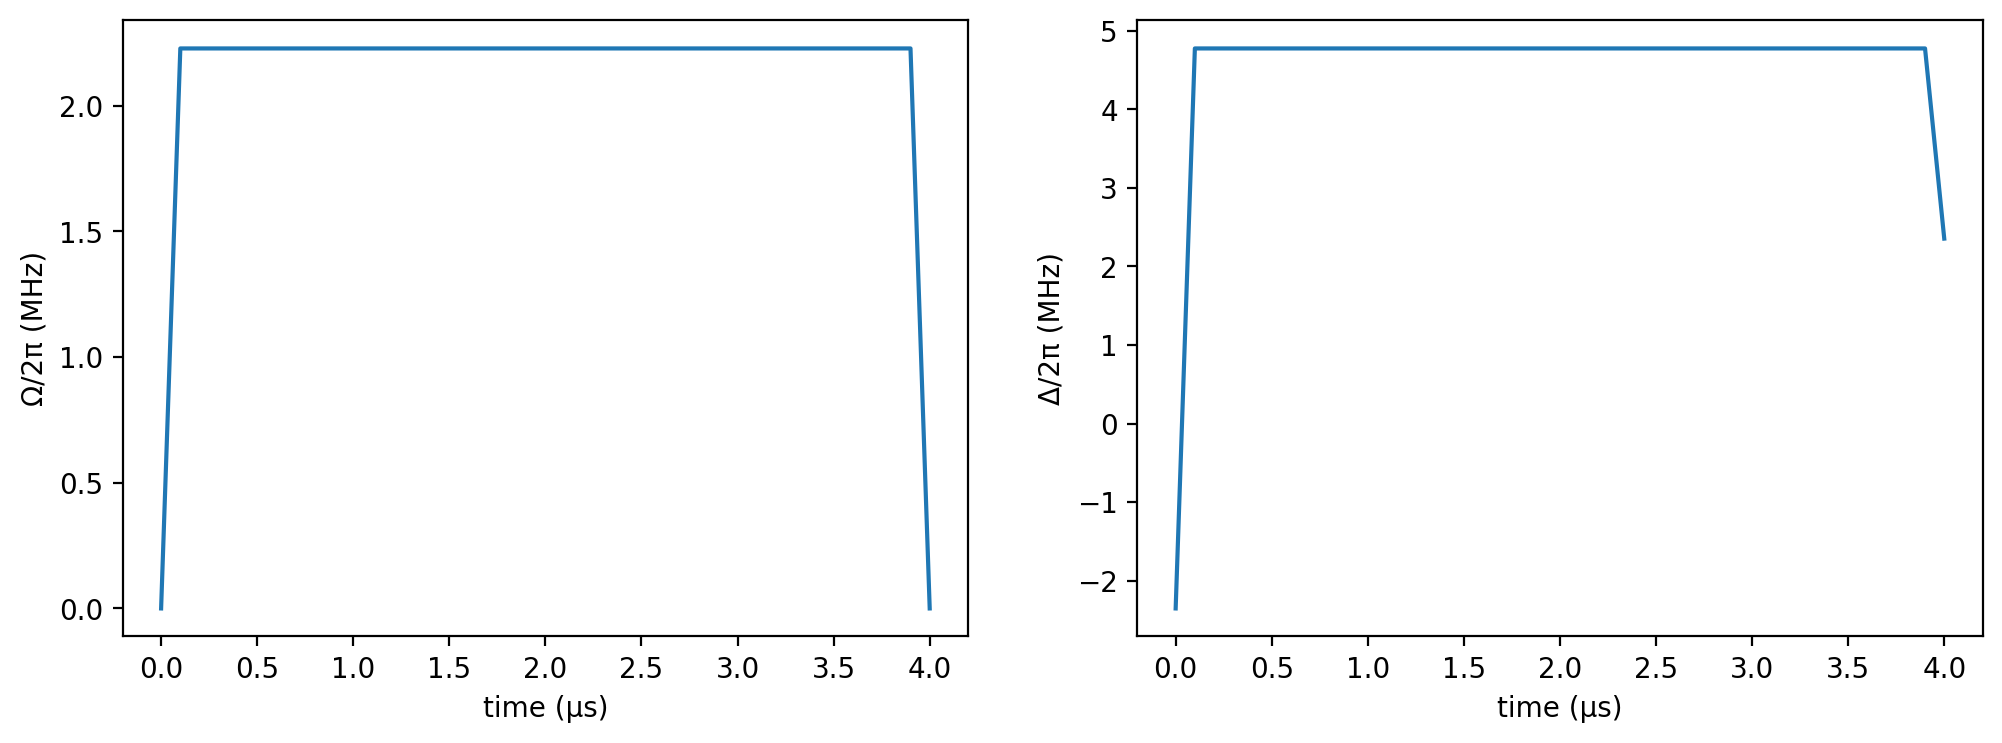

In [195]:
# Here, we generalize the quantum adiabatic algorithm used in 
# the [Adiabatic Evolution](@ref) tutorial to prepare ground states of the Rydberg Hamiltonian for this disordered lattice.
# We first construct the adiabatic pulse sequences for the Rabi frequency ``\Omega`` and the detuning ``\Delta``:

T_max = 4
Ω_max = 14
Ω = piecewise_linear(clocks = [0.0, 0.1, 3.9, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -14.79
Δ_end = 14.79
Δ = piecewise_linear(clocks = [0.0, 0.1, 3.9, T_max], values = [Δ_start, 30, 30, Δ_end])

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig


# Here, the total time is fixed to `T_max`, the adiabatic evolution path is specified by the [`piecewise_linear`](@ref) function.
# The Rydberg blockade radius can be computed with 
# ```math
# C_6 / R_b^6 \sim \sqrt{\Delta^2 + \Omega^2}
# ```
# The default for ``C_6=2π * 862690 \text{ MHz μm}^6``.
# For encoding the corresponding MIS problem at ``\Omega = 0``, 
# the detuning can be set around ``2\pi \times 11`` MHz 
# for a blockade radius of ``7.5`` µm
# (see the parameters in [S. Ebadi et al. (10.48550/arXiv.2202.09372)](https://arxiv.org/abs/2202.09372)).

In [196]:
# Next, we create the time-dependent Hamiltonian and simulate its time evolution by using the [`SchrodingerProblem`](@ref) solver:
# This is where we could wrap a timing function to compare the time spent performing the Adiabatic Approach

hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 4.0)

  equation: 
    storage size: 15.023 KiB
    expression:
nqubits: 7
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


    algorithm: DP8(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)
  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false
    reltol: 1.0e-10
    abstol: 1.0e-10
    alias_u0: true


# Visualizing and Confirming the Adiabatic Approach:

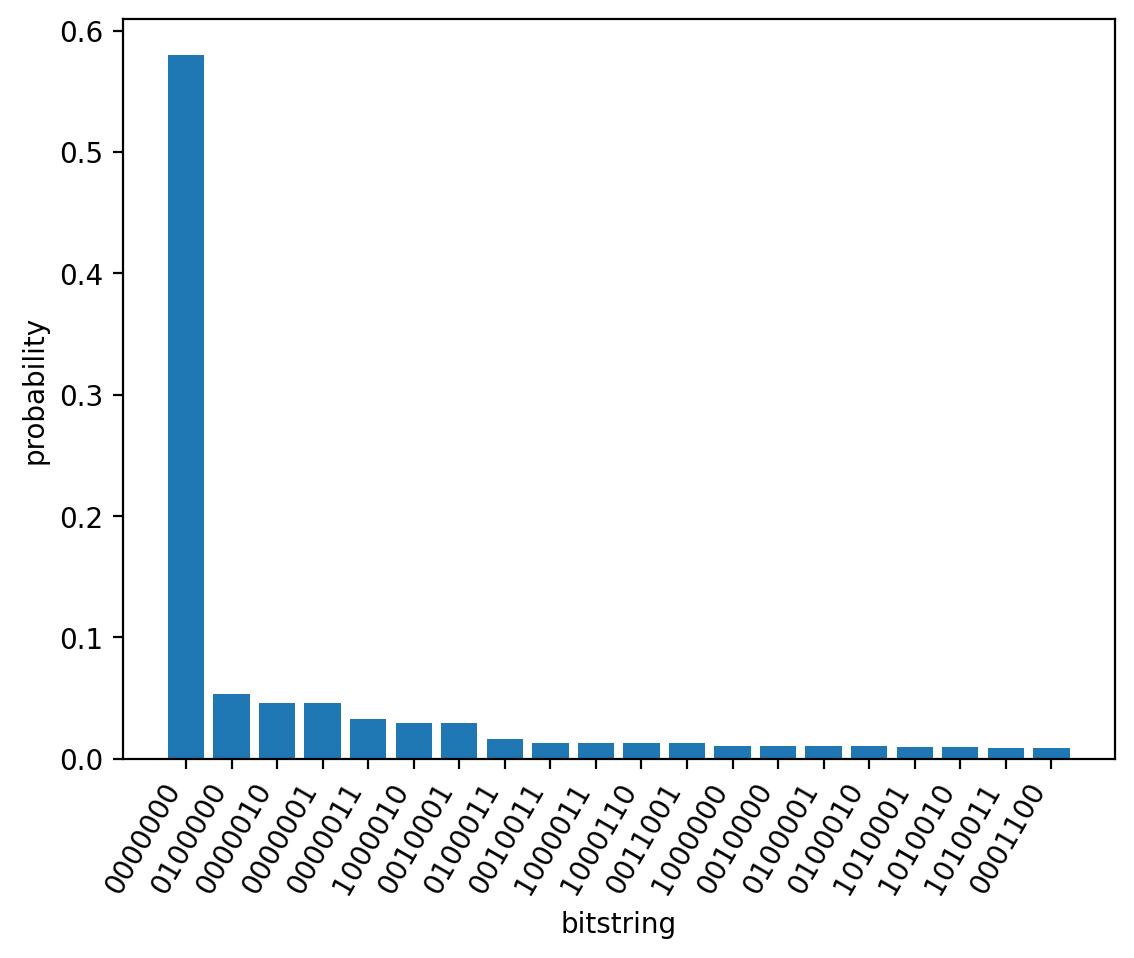

In [197]:
# Finally, we can plot the most probable bitstrings by using the [`bitstring_hist`](@ref) function on the resulting register (quantum state):
bitstring_hist(prob.reg; nlargest = 20)

In [198]:
# We can see that some of the most probable configurations indeed have an independent set size 4 by counting the number of ones in the bitstring.
# The correctness of the output can be verified by comparing it to the classical solution:

best_bit_strings = most_probable(prob.reg, 2)
all_optimal_configs = GenericTensorNetworks.solve(IndependentSet(graph), ConfigsMax())[]
@assert all(bs -> GenericTensorNetworks.StaticBitVector([bs...]) ∈ all_optimal_configs.c, best_bit_strings)

LoadError: AssertionError: all((bs->begin
            #= In[198]:6 =#
            GenericTensorNetworks.StaticBitVector([bs...]) ∈ all_optimal_configs.c
        end), best_bit_strings)

In [ ]:
# a calculation of the probability that the we have a correctly sized MIS 
# in our top 5 all_optimal_configs

function get_MIS_prob(reg::Union{ArrayReg, SubspaceArrayReg}, configs) # want to maxmimize this
    prob = 0
    x = [parse(Int, reverse(string(x)); base=2) for x in configs.c]
    for (c, amp) in BloqadeMIS.ConfigAmplitude(reg)
        if c in x
            prob+=abs2(amp)
        end
    end
    return prob
end

configs = GenericTensorNetworks.solve(IndependentSet(graph), ConfigsMax())[]
get_MIS_prob(prob.reg, configs)



0.205408730417326

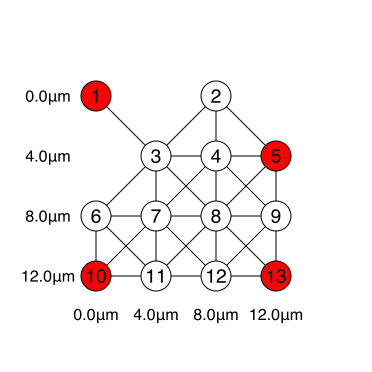

In [ ]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b ∈ best_bit_strings[1]])


In [ ]:
# However, there are still some configurations that violate the blockade constraint, 
# because the blockade interaction is not an ideal unit disk constraint (e.g. some bitstrings have a size 5).
# One can check whether the independence constraint is satisfied or not with the [`BloqadeMIS.is_independent_set`](@ref) function:
best3_bit_strings = most_probable(prob.reg, 3)
print(best3_bit_strings)
BloqadeMIS.is_independent_set.(best3_bit_strings, Ref(graph))

# for i in range(3)
#     if best3_bit_strings[i] in configs
#         print(best3_bit_strings[i], "is MIS")
#     else
#         print(best3_bit_strings[i], "is not MIS")
#     end
# end
#TODO: check if max independent set. Make above work
# mis_size_and_counting #(size of MIS, number of sets of that size)

DitStr{2, 7, Int64}[0001000 ₍₂₎, 0000100 ₍₂₎, 0000000 ₍₂₎]

LoadError: ArgumentError: Cannot construct range from arguments:
start = 3
step = nothing
stop = nothing
length = nothing
Try specifying more arguments.


In [ ]:
# NOTE: This compares to the classical graph. We are going to have to modify this when we are working
# with things beyond classical capabilities.

# This happens because the Rydberg interaction is not very strong at the unit disk radius 
# You can fix this issue by using mis_postprocessing function. This will remove any dependent set 
fixed = mis_postprocessing(best5_bit_strings[3], graph)
BloqadeMIS.is_independent_set(fixed, graph)

true